# VGAEのデモンストレーション
- VGAEを活用
    - エンコーダー: GCN
    - デコーダー: InnerDecoder
- Coraネットワークを利用してネットワークを生成する


GPU PyTorchの動作確認

In [1]:
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.12.11 (main, Jul  3 2025, 17:03:59) [GCC 11.4.0]
PyTorch：2.7.1+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得

- CORAネットワーク
    - 論文索引関係を表すネットワーク

### 取得したCoraデータを変換

- CoraのテストデータをPyTorchのデータ型に変換
- 変換したデータ分割する

In [4]:
# networkxのグラフをtorch_geometricのDataに変換
from torch_geometric.datasets import Planetoid 
from torch_geometric.utils import (
    train_test_split_edges,
)

# Cora の citation ネットワーク (2,708 ノード / 5,429 エッジ)
data = Planetoid(root='/tmp', name='Cora')[0]
data.train_mask = data.val_mask = data.test_mask = None      # ノード分類用マスクは不要

# エッジをトレーニング、検証、テストセットに分割
data = train_test_split_edges(data)

print("Node Features:", data.x.shape)

Node Features: torch.Size([2708, 1433])


### 取得したデータを可視化

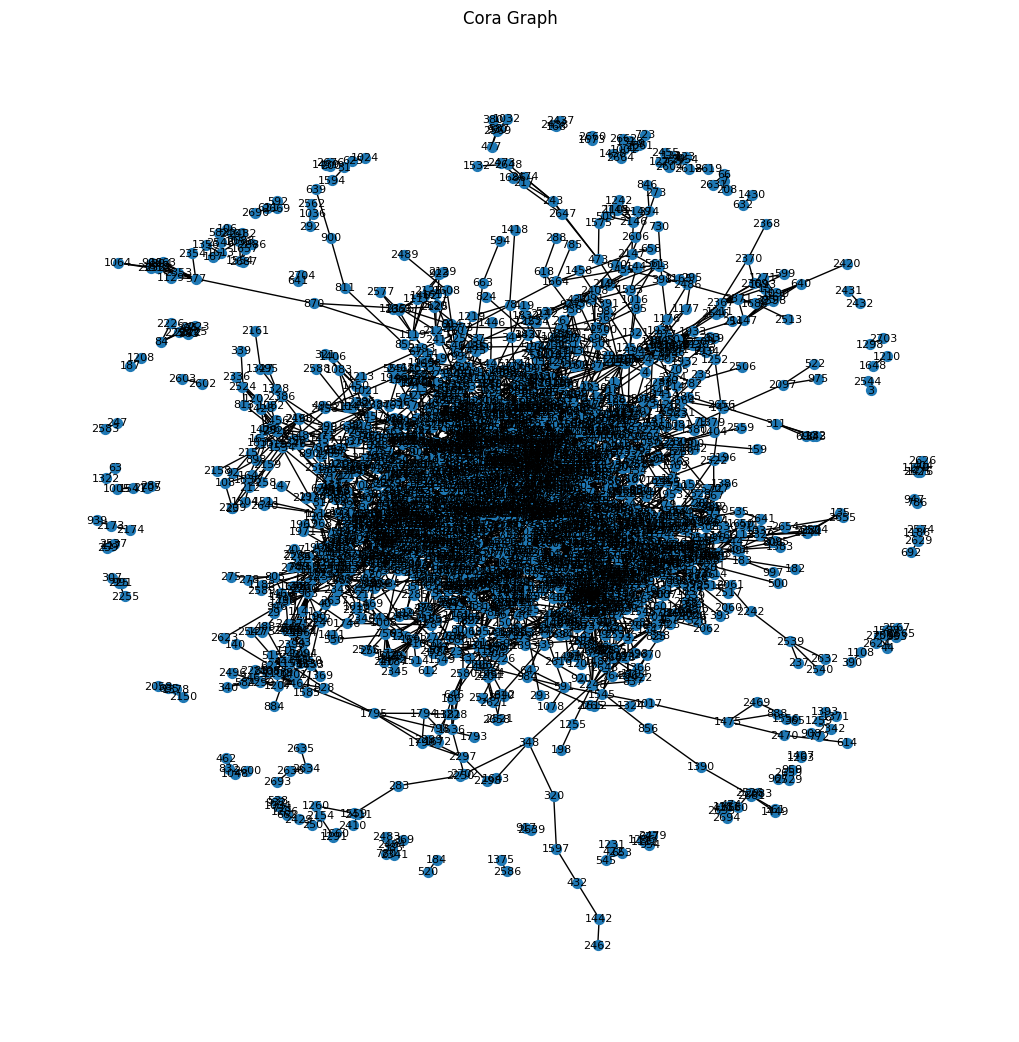

In [5]:
# データを可視化
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G.add_edges_from(data.train_pos_edge_index.t().tolist())

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Cora Graph")
plt.show()

## VGANを活用したグラフ生成

- Variational Graph Auto-encoder
- 既存のグラフを学習し新たなグラフを生成する

### VGAEモデルの定義

- Graph Encoder: Graph Convolution Network(GCN)
- Graph Decoder: InnerDecoder


In [6]:
from torch_geometric.nn import GCNConv, VGAE

# Encoderの定義
class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

in_channels = data.x.size(-1) # 入力される特徴量の次元
out_channels = 3 # 出力される特徴量の次元
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")
model = VGAE(GraphEncoder(in_channels=in_channels, out_channels=out_channels)) # エンコーダとデコーダーを合わせてモデルのインスタンス化

入力特徴量の次元: 1433, 出力特徴量の次元: 3


### モデルの学習
- パラメータの更新: Adam
- 目的関数
    - 再構成誤差: recon_loss
    - KLダイバージェンス: KL_loss

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) # 利用するデバイスを選択
data = data.to(device)  # データをGPUに転送
best_loss = float('inf') # 最良モデルの追跡用変数
best_model = None # 最良モデルの保存用変数

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    recon_loss = model.recon_loss(z, data.train_pos_edge_index)
    kl_loss = (1 / data.num_nodes) * model.kl_loss()
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 301):
    loss = train()
    # 現在のエポックでのlossが最良の場合、モデルを保存
    if loss < best_loss:
        best_loss = loss
        # モデルの保存
        best_model = model

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')
model = best_model  # 最良モデルを使用 


Epoch 50, Loss: 0.9939878582954407
Epoch 100, Loss: 0.9649955034255981
Epoch 150, Loss: 0.9493537545204163
Epoch 200, Loss: 0.9668148159980774
Epoch 250, Loss: 0.9489734172821045
Epoch 300, Loss: 0.9451466202735901


### ネットワークの生成
- 学習したモデルを用いてネットワークを生成する
- 潜在変数$Z$を可視化

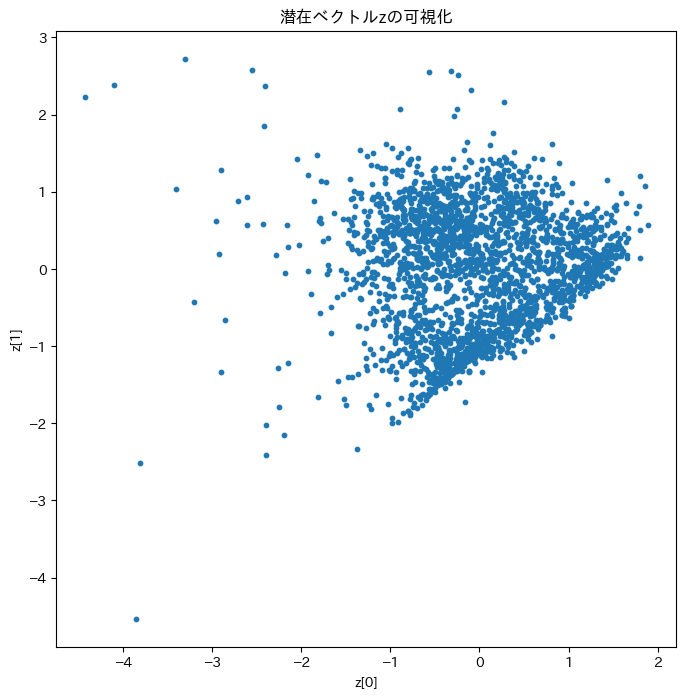

In [18]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# ネットワークの生成
model = model.to(device)  # モデルをGPUに転送
data = data.to(device)  # データをGPUに転送

# ネットワークの生成
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.train_pos_edge_index)  # エンコーダを使用して潜在ベクトルzを生成
    # 潜在ベクトルzの可視化
    plt.figure(figsize=(8, 8))
    plt.scatter(z[:, 0].cpu(), z[:, 1].cpu(), s=10)
    plt.title("潜在ベクトルzの可視化")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # 潜在ベクトルzをデコードして隣接行列を生成
    adj = z @ z.t()  # xとzの内積を計算して隣接行列を生成
    adj = torch.sigmoid(adj)  # Sigmoid関数を適用して隣接行列を確率に変換
    tau = 0.5
    adj_matrix = (adj > tau).nonzero(as_tuple=False).t()
    sample = adj_matrix[:, torch.randperm(adj_matrix.size(1))[:data.num_edges]]  # エッジをサンプリング

### 生成したネットワークの可視化

生成されたグラフ: ノード数=2708, エッジ数=263


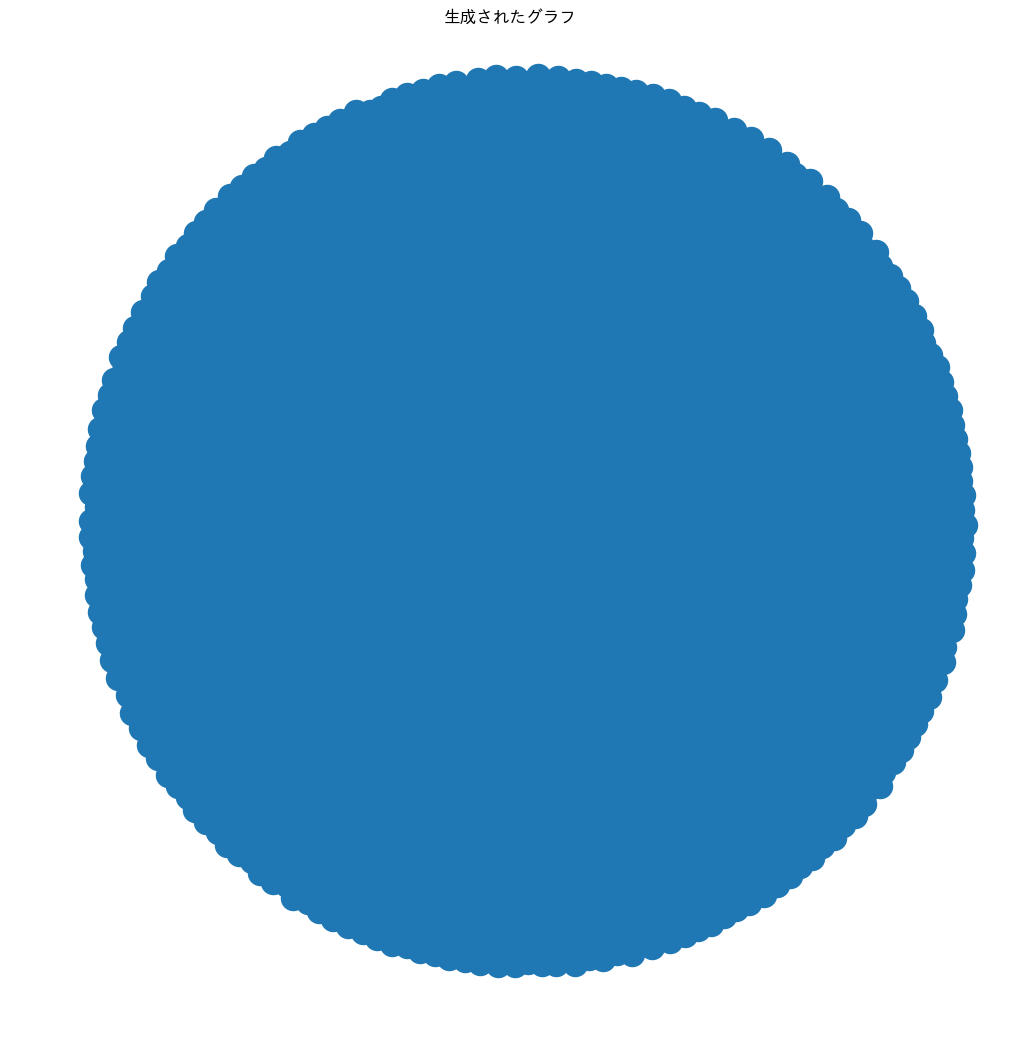

In [21]:
g_gen = nx.DiGraph()  # 有向グラフの作成
g_gen.add_nodes_from(range(data.num_nodes))  # ノードを追加
g_gen.add_edges_from(sample.t().cpu().numpy())  # エッジを追加
print(f"生成されたグラフ: ノード数={g_gen.number_of_nodes()}, エッジ数={g_gen.number_of_edges()}")

plt.figure(figsize=(8, 8))
nx.draw(g_gen, with_labels=False)
plt.title("生成されたグラフ")
plt.show()